<a href="https://colab.research.google.com/github/3ndung/Markisa_Machine_Learning_Tyo/blob/main/Markisa_Tyo_HUB_EFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Latar Belakang**  

Pemanfaatan multidisiplin ilmu sangat memungkian, pada kasus kali ini adalah pemanfaatan Machine Learning sebagai bagian kecerdasaan buatan untuk usaha pertanian kecil yang dalam hal ini adalah untuk membedakan mana buah markisa yang baik dan tidak baik secara fisik.

# Objective  
1. Model Pembelajaran dari Machine learning dapat membedakan Markisa Baik dan Markisa tidak baik
2. ...

# **Import Library Python yang akan digunakan untuk Pembelajaran**

## Pemanfaatan Pustaka Machine Learning Tensorflow yang dikembangkan oleh google

In [46]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [74]:
import tensorflowjs as tfjs

In [7]:
print(tf.__version__)
print(hub.__version__)

2.4.1
0.11.0


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt


## **Pemanggilan Gambar Markisa baik dan tidak baik sebagai dataset yang akan digunakan dalam pembelajaran**

In [4]:
# kali ini kita coba melakukan penyimpanan clound di google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set Train Path Only


In [8]:
TPATH = '/content/drive/MyDrive/MARKISA/HUB/'

In [9]:
ls $TPATH

Markisa_Kondisi_Baik/  Markisa_Kurang_Baik/


## Mensetting ukuran gambar yang akan digunakan sebagai dataset  
Dalam hal ini kita menggunakan ukuran 224 x 224 

In [10]:
IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(TPATH, target_size=IMAGE_SHAPE)

Found 200 images belonging to 2 classes.


In [12]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


**Catatan Kecil **

fungsi ImageDataGenerator diatas adalah mengkonversi gambar ke dalam format array


Karena kita hanya memiliki dua kelas yaitu Markisa baik dan kurang baik maka,label yang akan kita dapat adalah [0,1] dan [1,0]

In [14]:
print(label_batch[0])
print(label_batch[6])

[1. 0.]
[1. 0.]


# **Pemanfaatan Ulang Arsitektur yang telah dikembangkan google**  
## mobilenet_v2

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

# Efficiencinet

In [15]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b1/classification/1" #@param {type:"string"}

In [16]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1000)


if we dont want training anymore

In [17]:
feature_extractor_layer.trainable = False

# Penggunaan Mobilenet_v2 google sebagai lapisan pada model yang akan kita kembangkan untuk Pembelajaran

Model yang kita buat berikut bersifat sequential atau berurutan , dengan input array 224x224x3 ,menggunakan Mobilenet_v2 sebagai arsitekture middle layer dan single output

In [18]:
model = tf.keras.Sequential([
  #feature_extractor_layer, 
  hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3),trainable=False),
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1000)              7856232   
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 7,858,234
Trainable params: 2,002
Non-trainable params: 7,856,232
_________________________________________________________________


In [19]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 2])

Model kompliasi yang akan digunakan adalah Adam Optimizer, dengan fungsi error/loss yang digunakan adalah CategoricalCrossentropy dan metrik yang digunakan adalah akurasi

In [20]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

# **Lets Run**  
pada kesempatan kali ini kita akan menggunakan 10 iterasi ( tapi lebih pun tidak apa, namun jika accuraci nya tergolong baik gunakan iterasi secukupnya saja)

In [22]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=4,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/4
7/7 [==============================] - 34s 4s/step - loss: 0.9735 - accuracy: 0.5781
Epoch 2/4
7/7 [==============================] - 30s 4s/step - loss: 0.0895 - accuracy: 0.9922
Epoch 3/4
7/7 [==============================] - 30s 4s/step - loss: 0.0181 - accuracy: 1.0000
Epoch 4/4
7/7 [==============================] - 30s 4s/step - loss: 0.0082 - accuracy: 1.0000


# **Plotting Learning Curve**  
Learning Curve dibawah ini merupakan visaulisasi iterasi pembelajaran pada proses diatas

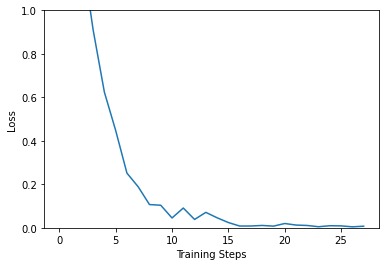

In [23]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_losses)

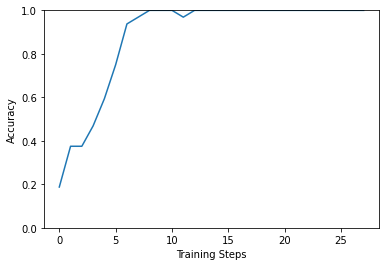

In [24]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [25]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Markisa_Kondisi_Baik', 'Markisa_Kurang_Baik'], dtype='<U20')

In [26]:
class_names[0]='Markisa Kondisi Baik'
class_names[1]='Markisa Kurang Baik'

print(class_names)

['Markisa Kondisi Baik' 'Markisa Kurang Baik']


In [36]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [37]:
label_id = np.argmax(label_batch, axis=-1)

# Prediction

Bagian ini mencoba menerka apakah ini markisa baik dan tidak baik, sebagai catatan predikti adalah 20% dari total data sedangkan pembelajaran menggunakan 80% data total 

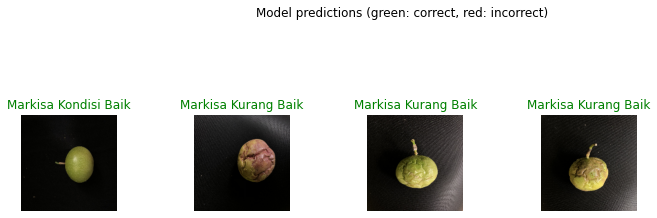

In [38]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(4):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Menyimpan Model untuk digunakan pada implementasi Machine Learning Selanjutnya

In [25]:
model.save('/content/drive/MyDrive/MARKISA/MODEL_EFF/Markisa_Tyo_HUB_EFF')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MARKISA/MODEL_EFF/Markisa_Tyo_HUB_EFF/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MARKISA/MODEL_EFF/Markisa_Tyo_HUB_EFF/assets


# SAVE TO JAVASCRIPT MODEL

In [75]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/MARKISA/MODEL_EFF/TFJV/')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


# **RECALL THE MODEL FOR PREDICTION**

In [68]:
model_load = tf.keras.models.load_model('/content/drive/MyDrive/MARKISA/MODEL_EFF/Markisa_Tyo_HUB_EFF')

def PRDS(x):
  img = keras.preprocessing.image.load_img(tf.keras.utils.get_file('Test_Prediksi', origin=x), target_size=(224, 224,3))
  plt.imshow(img)
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model_load.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  #score = tf.nn.sigmoid(predictions[0])
  print(np.argmax(score))

  if np.argmax(score) == 1:
    print(f' KURANG BAIK {100* np.max(score)} %')
  else:
    print(f' BAIK {100* np.max(score)} %')  




Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7f2ef475b170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

# **PREDIKSION MARKISA IMAGE FROM NETWORK**

1
 KURANG BAIK 100.0 %


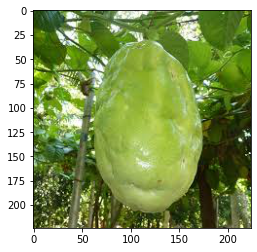

In [69]:
TT = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRdW_p8Og9oM2EA88FMbRaCreu7mbGLoLFFHw&usqp=CAU"

PRDS(TT)